In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from statistics import median, mean
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# Load models (axial and vector)
inputFiles = ['../validation/CMS-EXO-20-004/scanResults_axial_reduced.pcl',
              '../validation/CMS-EXO-20-004/scanResults_vector_reduced.pcl']
dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

295 models loaded.


### Get model parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Axial', 'Vector'], 'Mode': 'DM+QCDjets', '$m_{med}$': [450.0, 1250.0, 100.0, 2500.0, 1000.0, 2250.0, 300.0, 750.0, 400.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 900.0, 650.0, 400.0, 800.0, 300.0, 1200.0, 60.0, 700.0, 450.0, 200.0, 1100.0, 600.0, 120.0, 100.0, 1000.0, 750.0, 500.0, 1400.0, 250.0]}
Coupling = ['Axial', 'Vector']
Mode = DM+QCDjets


### Obtain Efficiencies

In [5]:
label = [c for c in recastData if (c.startswith("bin_") and not 'Error' in c)]

for l in label:
    ns = recastData[l]
    lumi = recastData['Luminosity (1/fb)']
    xsec = recastData['Total xsec (pb)']
    recastData[f'{l}_Efficiency'] = ns/(1e3*xsec*lumi)

# Obtain the median of the binned efficiencies
# recastData['Median_Efficiency'] = recastData[[f'{l}_Efficiency' for l in label]].apply(median, axis=1)      

In [6]:
# Select year
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [7]:
dataAx = recastData[recastData['Coupling'] == 'Axial']
dataVec = recastData[recastData['Coupling'] == 'Vector']

In [8]:
# Setting the index with mass pairs
effAx = pd.DataFrame([dataAx.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])
effVec = pd.DataFrame([dataVec.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])

In [9]:
effAx

$m_{med}$                           100.0                                 \
$m_{DM}$                            1.0       100.0     200.0     300.0    
bin_250.0_280.0_Efficiency    2.265363e-04  0.002871  0.007123  0.010461   
bin_280.0_310.0_Efficiency    1.302404e-04  0.002237  0.005779  0.006375   
bin_310.0_340.0_Efficiency    9.495179e-05  0.001581  0.003838  0.005725   
bin_340.0_370.0_Efficiency    4.566904e-05  0.001041  0.003051  0.005284   
bin_370.0_400.0_Efficiency    2.856821e-05  0.000728  0.001985  0.003790   
bin_400.0_430.0_Efficiency    2.739897e-05  0.000532  0.001796  0.002262   
bin_430.0_470.0_Efficiency    1.877315e-05  0.000504  0.001701  0.003264   
bin_470.0_510.0_Efficiency    1.035762e-05  0.000390  0.001081  0.002066   
bin_510.0_550.0_Efficiency    3.172888e-06  0.000231  0.000662  0.001781   
bin_550.0_590.0_Efficiency    4.848818e-06  0.000128  0.000548  0.001211   
bin_590.0_640.0_Efficiency    4.073150e-06  0.000147  0.000558  0.000974   
bin_640.0_690.0_Efficiency    1.259397e-06  0.000100  0.000430  0.000720   
bin_690.0_740.0_Efficiency    2.035113e-06  0.000084  0.000253  0.000507   
bin_740.0_790.0_Efficiency    9.395425e-07  0.000040  0.000174  0.000329   
bin_790.0_840.0_Efficiency    6.400465e-07  0.000040  0.000124  0.000209   
bin_840.0_900.0_Efficiency    1.658751e-07  0.000022  0.000186  0.000249   
bin_900.0_960.0_Efficiency    2.645171e-07  0.000016  0.000106  0.000167   
bin_960.0_1020.0_Efficiency   3.807527e-07  0.000010  0.000052  0.000105   
bin_1020.0_1090.0_Efficiency  0.000000e+00  0.000009  0.000068  0.000098   
bin_1090.0_1160.0_Efficiency  9.619586e-08  0.000006  0.000032  0.000078   
bin_1160.0_1250.0_Efficiency  0.000000e+00  0.000005  0.000023  0.000072   
bin_1250.0_1400.0_Efficiency  2.682149e-08  0.000006  0.000042  0.000092   

$m_{med}$                                                             \
$m_{DM}$                        400.0     500.0     600.0     700.0    
bin_250.0_280.0_Efficiency    0.012731  0.011850  0.013852  0.016098   
bin_280.0_310.0_Efficiency    0.009373  0.011238  0.009634  0.009530   
bin_310.0_340.0_Efficiency    0.006001  0.008250  0.008283  0.007866   
bin_340.0_370.0_Efficiency    0.005686  0.006432  0.007331  0.008504   
bin_370.0_400.0_Efficiency    0.005740  0.005570  0.007959  0.005868   
bin_400.0_430.0_Efficiency    0.003090  0.004961  0.004649  0.005659   
bin_430.0_470.0_Efficiency    0.004503  0.003304  0.004183  0.005995   
bin_470.0_510.0_Efficiency    0.002419  0.002716  0.002989  0.003230   
bin_510.0_550.0_Efficiency    0.001596  0.002166  0.002528  0.002846   
bin_550.0_590.0_Efficiency    0.001439  0.001964  0.002655  0.002004   
bin_590.0_640.0_Efficiency    0.001338  0.002074  0.002002  0.002307   
bin_640.0_690.0_Efficiency    0.001108  0.001785  0.001375  0.002273   
bin_690.0_740.0_Efficiency    0.000739  0.000988  0.002091  0.001249   
bin_740.0_790.0_Efficiency    0.000626  0.000791  0.001405  0.002193   
bin_790.0_840.0_Efficiency    0.000476  0.000404  0.000720  0.000798   
bin_840.0_900.0_Efficiency    0.000398  0.000612  0.000613  0.000739   
bin_900.0_960.0_Efficiency    0.000450  0.000316  0.000385  0.000610   
bin_960.0_1020.0_Efficiency   0.000204  0.000169  0.000339  0.000479   
bin_1020.0_1090.0_Efficiency  0.000206  0.000298  0.000237  0.000246   
bin_1090.0_1160.0_Efficiency  0.000106  0.000140  0.000189  0.000226   
bin_1160.0_1250.0_Efficiency  0.000112  0.000201  0.000169  0.000213   
bin_1250.0_1400.0_Efficiency  0.000160  0.000244  0.000280  0.000359   

$m_{med}$                                         ...    2750.0            \
$m_{DM}$                        800.0     1000.0  ...    600.0     800.0    
bin_250.0_280.0_Efficiency    0.015438  0.015333  ...  0.014191  0.012704   
bin_280.0_310.0_Efficiency    0.012463  0.012008  ...  0.009519  0.009680   
bin_310.0_340.0_Efficiency    0.008623  0.009208  ...  0.007334  0.008367   
bin_340.0_370.0_Efficiency    0.007508  0.007948  ...  0.0056

In [10]:
diff = []
for med, dm in effVec:
    d = np.abs(effAx[med, dm] - effVec[med, dm])/effAx[med, dm]
    d = d.replace(np.inf, 0)
    d = d.max()
    diff.append(d)

In [11]:
len(diff)

147

In [12]:
max(diff)

12.00581977354025

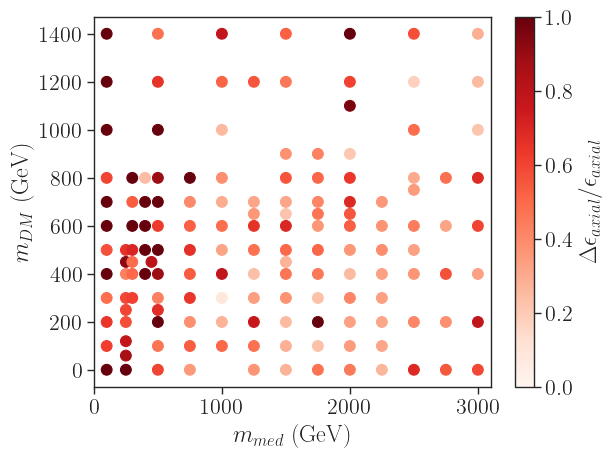

In [14]:
# Plot results
plt.scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=diff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'$\Delta \epsilon_{axial}/\epsilon_{axial}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [15]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  diff,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

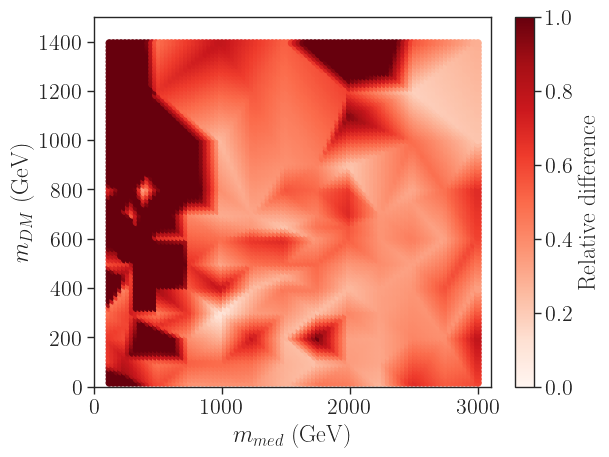

In [16]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1500)
plt.show()

In [17]:
def getBins(dfModel,rightBin = 2000.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'Efficiency' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return binsEff,binsError,binCenter,binLeft

In [ ]:
# Create function that receives two dataframes, compares the efficiency in each bin, 
# and then returns the largest relative difference

def getRelativeDifference(dfSingle1, dfSingle2, binsEff):
    pass
    
    